## **LazyPredict in nnetsauce v0.15.0 for Multivariate time series (MTS)**

Keep in mind that VAR and VECM aren't thoroughly trained here. `nnetsauce.MTS` isn't really tuned either. This is just a demo. To finish, a probabilistic error metric is better for models capturing forecasting uncertainty.

**Contents**

- 1 - Install
- 2 - MTS
- 2 - 1 nnetsauce.MTS
- 2 - 2 statsmodels VAR
- 2 - 3 statsmodels VECM

# **1 - Install**

In [ ]:
!pip install git+https://github.com/Techtonique/nnetsauce.git@lazy-predict

In [17]:
import nnetsauce as ns
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str
from sklearn.linear_model import LassoCV
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.vector_ar.vecm import VECM, select_order
from statsmodels.tsa.base.datetools import dates_from_str

# **2 - MTS**

Macro data

In [ ]:
# some example data
mdata = sm.datasets.macrodata.load_pandas().data

# prepare the dates index
dates = mdata[['year', 'quarter']].astype(int).astype(str)

quarterly = dates["year"] + "Q" + dates["quarter"]

quarterly = dates_from_str(quarterly)

print(mdata.head())

#mdata = mdata[['realgdp','realcons','realinv', 'realgovt',
#               'realdpi', 'cpi', 'm1', 'tbilrate', 'unemp',
#               'pop']]

mdata = mdata[['realgovt', 'tbilrate']]

mdata.index = pd.DatetimeIndex(quarterly)

data = np.log(mdata).diff().dropna()

#data = mdata

display(data)

In [ ]:
df = data
#df.set_index('Month', inplace=True)
df.index.rename('date')

idx_train = int(df.shape[0]*0.8)
idx_end = df.shape[0]
df_train = df.iloc[0:idx_train,]
df_test = df.iloc[idx_train:idx_end,]

regr_mts = ns.LazyMTS(verbose=1, ignore_warnings=True, custom_metric=None,
                      lags = 1, n_hidden_features=3, n_clusters=0, random_state=1)
models, predictions = regr_mts.fit(df_train, df_test)
model_dictionary = regr_mts.provide_models(df_train, df_test)

In [20]:
display(models)

,RMSE,MAE,MPL,Time Taken
Model,,,,
LassoCV,0.22,0.12,0.06,0.20
ElasticNetCV,0.22,0.12,0.06,0.19
LassoLarsCV,0.22,0.12,0.06,0.08
LarsCV,0.22,0.12,0.06,0.08
DummyRegressor,0.22,0.12,0.06,0.06
ElasticNet,0.22,0.12,0.06,0.07
LassoLars,0.22,0.12,0.06,0.06
Lasso,0.22,0.12,0.06,0.07
ExtraTreeRegressor,0.22,0.14,0.07,0.12


In [21]:
model_dictionary['LassoCV']

MTS(n_clusters=0, n_hidden_features=3, obj=LassoCV(random_state=1), seed='mean')

## **2 - 1 - `nnetsauce.MTS`**

In [22]:
regr = ns.MTS(obj = LassoCV(random_state=1),
              lags = 1, n_hidden_features=3,
              n_clusters=0, replications = 250,
              kernel = "gaussian", verbose = 1)

In [23]:
regr.fit(df_train)


 Adjusting LassoCV to multivariate time series... 
 


100%|██████████| 2/2 [00:00<00:00,  6.22it/s]



 Simulate residuals using gaussian kernel... 


 Best parameters for gaussian kernel: {'bandwidth': 0.04037017258596558} 



MTS(kernel='gaussian', n_clusters=0, n_hidden_features=3,
    obj=LassoCV(random_state=1), replications=250, verbose=1)

In [24]:
res = regr.predict(h=df_test.shape[0], level=95)

100%|██████████| 250/250 [00:00<00:00, 6971.82it/s]


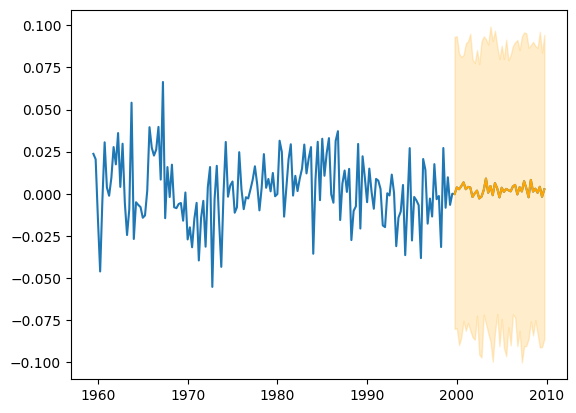

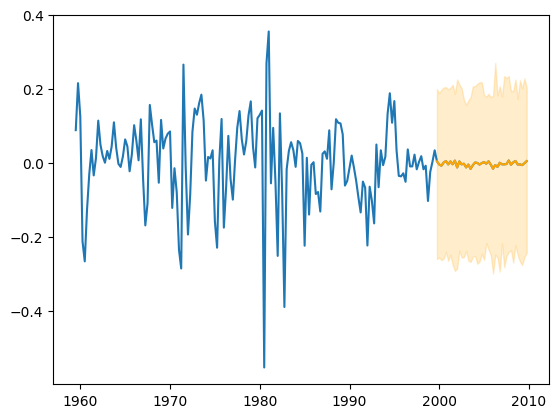

In [25]:
regr.plot("realgovt")
regr.plot("tbilrate")

## **2 - 2 - VAR**

In [ ]:
model = VAR(df_train)
results = model.fit(maxlags=5, ic='aic')
lag_order = results.k_ar
VAR_preds = results.forecast(df_train.values[-lag_order:], df_test.shape[0])

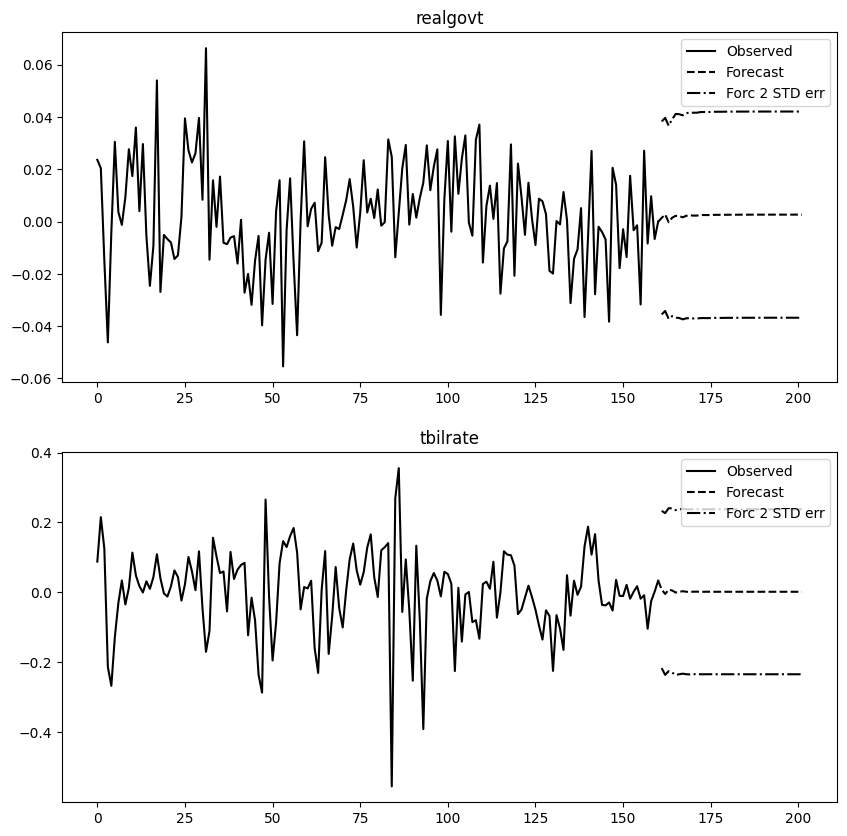

In [27]:
results.plot_forecast(steps = df_test.shape[0]);

## **2 - 3 - VECM**

In [ ]:
model = VECM(df_train, k_ar_diff=2, coint_rank=2)
vecm_res = model.fit()
vecm_res.gamma.round(4)
vecm_res.summary()
vecm_res.predict(steps=df_test.shape[0])
forecast, lower, upper = vecm_res.predict(df_test.shape[0], 0.05)

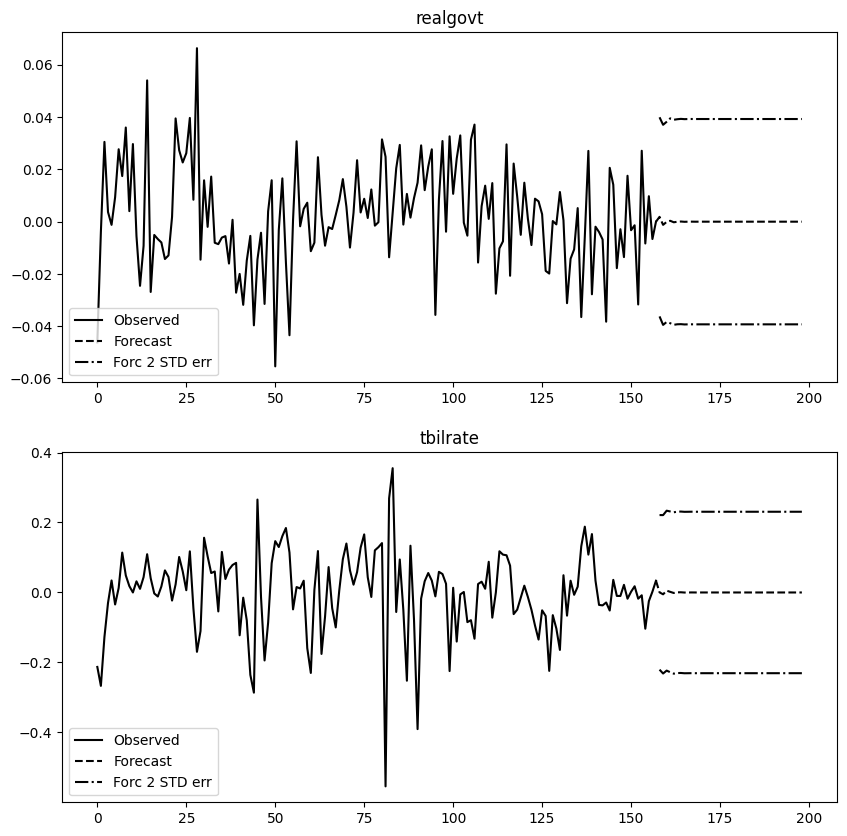

In [29]:
vecm_res.plot_forecast(steps = df_test.shape[0])

out-of-sample errors

In [30]:
display([("nnetsauce.MTS+"+models.index[i], models["RMSE"].iloc[i]) for i in range(3)])
display(('VAR', mean_squared_error(df_test.values, VAR_preds, squared=False)))
display(('VECM', mean_squared_error(df_test.values, forecast, squared=False)))

[('nnetsauce.MTS+LassoCV', 0.22102547609924011),
 ('nnetsauce.MTS+ElasticNetCV', 0.22103106562991648),
 ('nnetsauce.MTS+LassoLarsCV', 0.22103468506703655)]

('VAR', 0.22128770514262763)

('VECM', 0.22170093788693065)